# Data labeling for evaluating TSDR accuracy with CNN model

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

In [3]:
class_to_category: dict[int, str] = {
    0: 'Fluctuations/anomaly_during_fault',
    1: 'Level shift down/anomaly_during_fault',
    2: 'Level shift down/anomaly_outside_fault',
    3: 'Level shift up/anomaly_during_fault',
    4: 'Level shift up/anomaly_outside_fault',
    5: 'Multiple dips/anomaly_outside_fault',
    6: 'Multiple spikes/anomaly_during_fault',
    7: 'Multiple spikes/anomaly_outside_fault',
    8: 'Other normal/no_anomaly',
    9: 'Single dip/anomaly_during_fault',
    10: 'Single dip/anomaly_outside_fault',
    11: 'Single spike/anomaly_during_fault',
    12: 'Single spike/anomaly_outside_fault',
    13: 'Steady decrease/anomaly_during_fault',
    14: 'Steady increase/anomaly_during_fault',
    15: 'Sudden decrease/anomaly_during_fault',
    16: 'Sudden decrease/anomaly_outside_fault',
    17: 'Sudden increase/anomaly_during_fault',
    18: 'Transient level shift down/anomaly_during_fault',
    19: 'Transient level shift down/anomaly_outside_fault',
    20: 'Transient level shift up/anomaly_during_fault',
    21: 'Transient level shift up/anomaly_outside_fault',
    22: 'White noise/no_anomaly',
}

NORMAL_CLASSES: set[int] = set([8, 22])
ANONALY_CLASSES: set[int] = set([i for i in class_to_category.keys() if i not in NORMAL_CLASSES])

In [4]:
import sys
sys.path.append("../")
from diagnoser.cnn_model import CNN1d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

model = CNN1d(num_classes=len(class_to_category))
model.load_state_dict(torch.load("models/current_best_cnn1d.pth"))
model.eval()
torchinfo.summary(model, input_size=(1, 1, 180))

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [1, 23]                   --
├─Conv1d: 1-1                            [1, 64, 177]              320
├─Conv1d: 1-2                            [1, 128, 84]              32,896
├─Conv1d: 1-3                            [1, 256, 38]              131,328
├─Dropout: 1-4                           [1, 4608]                 --
├─Linear: 1-5                            [1, 64]                   294,976
├─BatchNorm1d: 1-6                       [1, 64]                   128
├─Dropout: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 23]                   1,495
Total params: 461,143
Trainable params: 461,143
Non-trainable params: 0
Total mult-adds (M): 8.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.84
Estimated Total Size (MB): 2.10

In [5]:
from notebooklib.save import load_tsdr

DATASET_ID = "qknmc"
datasets = load_tsdr(DATASET_ID)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
well_injected_fault_dataset_entries_texts: list[str] = """
carts/pod-cpu-hog/0
carts-db/pod-memory-hog/0
payment/pod-cpu-hog/0
user/pod-cpu-hog/0
catalogue-db/pod-memory-hog/0
catalogue/pod-cpu-hog/0
orders/pod-network-loss/0
orders/pod-cpu-hog/0
catalogue-db/pod-cpu-hog/0
user-db/pod-memory-hog/0
orders/pod-memory-hog/0
carts-db/pod-cpu-hog/0
orders-db/pod-cpu-hog/0
orders-db/pod-network-loss/0
orders-db/pod-memory-hog/0
user/pod-network-loss/0
payment/pod-network-loss/0
catalogue/pod-network-loss/0
catalogue-db/pod-network-loss/0
payment/pod-memory-hog/0
front-end/pod-memory-hog/0
user/pod-memory-hog/0
user-db/pod-cpu-hog/0
catalogue/pod-memory-hog/0
carts/pod-network-loss/0
front-end/pod-cpu-hog/0
carts-db/pod-network-loss/0
carts/pod-memory-hog/0
user-db/pod-network-loss/0
""".splitlines()
well_injected_fault_dataset_entries: list[tuple[str, str]] = [
    tuple(line.rstrip("/0").split("/")) for line in well_injected_fault_dataset_entries_texts
][1:]

well_injected_fault_datasets = [
    (record, filtered_df, anomalous_df, reduced_df) 
    for record, filtered_df, anomalous_df, reduced_df in datasets 
    if (record.chaos_comp(), record.chaos_type()) in well_injected_fault_dataset_entries
]

In [7]:
from torch.utils.data import Dataset
from sklearn.preprocessing import minmax_scale
from scipy.stats import zscore

from meltria import loader

NUM_METRICS_PER_BATCH = 100

class TSDataset(Dataset):
    def __init__(self, metrics_df: pd.DataFrame, class_to_category: dict[int, str]):
        super(TSDataset, self).__init__()
        self.metrics_df = metrics_df
        self.time_series = torch.tensor([
            self.metrics_df.loc[:, "time_series"].apply(lambda x: minmax_scale(x, feature_range=(0, 1))),
        ], dtype=torch.float32)  # use float64 to avoid error
        self.class_to_category = class_to_category

    def __getitem__(self, idx):
        return self.time_series[:, idx]

    def __len__(self):
        return len(self.metrics_df)

    def number_of_class(self) -> int:
        return len(self.class_to_category.keys())
    
    def categories(self) -> set[str]:
        return set(self.class_to_category.values())

def transform_to_testset(datasets: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]]) -> pd.DataFrame:
    items: list[dict] = []
    for record, filtered_df, _, _ in datasets:
        for col, ts in filtered_df.items():
            item = {
                "dataset_id": DATASET_ID,
                "target_app": record.target_app(),
                "chaos_comp": record.chaos_comp(),
                "chaos_type": record.chaos_type(),
                "metric": col,
                "time_series": ts.to_numpy(dtype=np.float64),
            }
            items.append(item)
    return pd.DataFrame(items)

def predict_anomaly_categories(
    records: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    nn_model: CNN1d,
    binary_pred: bool = False,
) -> pd.DataFrame:
    nn_model.eval()
    metrics_df: pd.DataFrame = transform_to_testset(records)
    dataset = TSDataset(metrics_df, class_to_category=class_to_category)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, pin_memory=True, shuffle=False)
    results: list[tuple[str, float]] = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            output, proba = nn_model(data)
            pred = output.argmax(dim=1, keepdim=True)
            pred_proba = proba.max(dim=1, keepdim=True).values
            for _pred, _pred_proba in zip(pred, pred_proba):
                pred_class = _pred.item()
                pred_category: str
                if binary_pred:
                    pred_category = "normal" if pred_class in NORMAL_CLASSES else "anomaly"
                else:
                    pred_category = dataset.class_to_category[pred_class]
                results.append((pred_category, _pred_proba.item()))
    return metrics_df.join(pd.DataFrame(results, columns=["anomaly_category", "probability"]))

In [8]:
predicted_df: pd.DataFrame = predict_anomaly_categories(
    well_injected_fault_datasets, model,
)

In [9]:
predicted_binary_df: pd.DataFrame = predict_anomaly_categories(
    well_injected_fault_datasets, model, binary_pred=True,
)

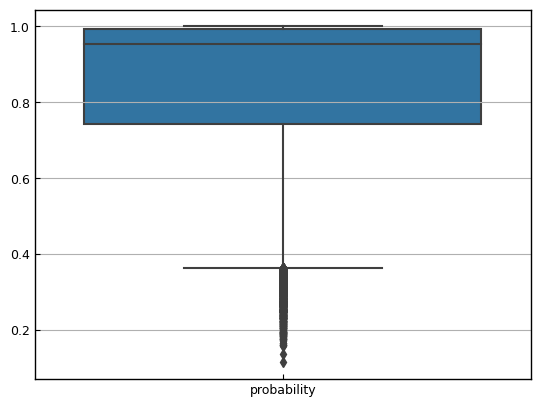

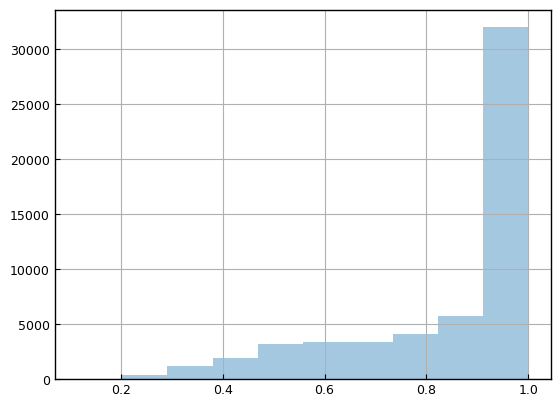

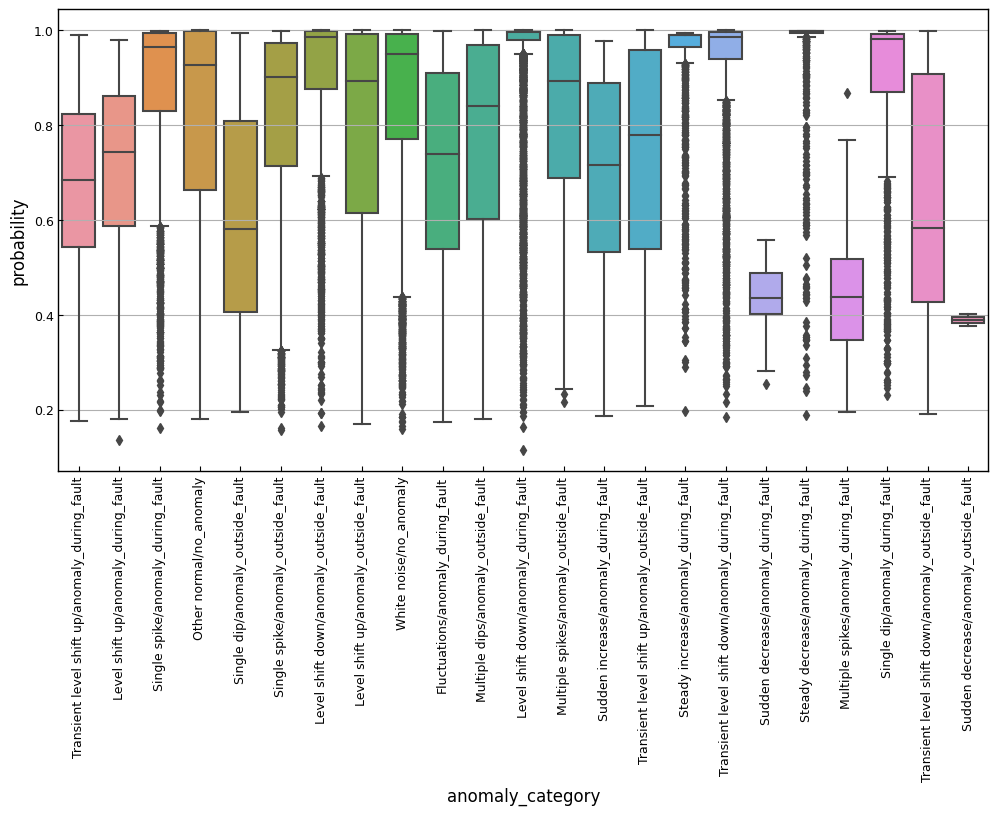

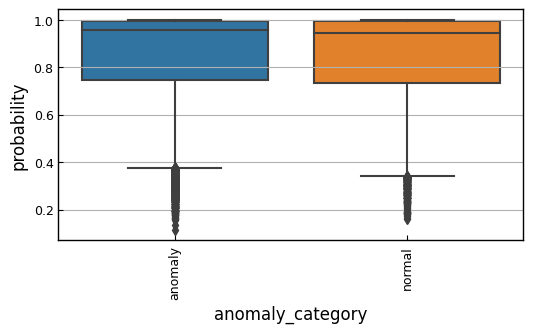

In [10]:
import seaborn as sns

sns.boxplot(data=predicted_df.loc[:, ["probability"]])
plt.show()

sns.distplot(predicted_df.loc[:, "probability"].values, kde=False, bins=10)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
_ax = sns.boxplot(data=predicted_df, x="anomaly_category", y="probability", ax=ax)
_ax.set_xticklabels(_ax.get_xticklabels(), rotation=90)
_ax.set_xlabel(_ax.get_xlabel(), fontsize=12)
_ax.set_ylabel(_ax.get_ylabel(), fontsize=12)
plt.show()

fig2, ax2 = plt.subplots(figsize=(6, 3))
_ax2 = sns.boxplot(data=predicted_binary_df, x="anomaly_category", y="probability", ax=ax2)
_ax2.set_xticklabels(_ax2.get_xticklabels(), rotation=90)
_ax2.set_xlabel(_ax2.get_xlabel(), fontsize=12)
_ax2.set_ylabel(_ax2.get_ylabel(), fontsize=12)
plt.show()

In [11]:
import math
from dataclasses import dataclass

import ipywidgets as widgets
from IPython.display import HTML

NUM_ITEMS_BY_PAGE: int = 20
NUM_FAULT_DATAPOINTS: int = (60 // 15) * 5  # 15 sec sampling to 5min


@dataclass(frozen=True)
class TSWindowForAL:
    num_total_categories: int
    num_current_categories: int
    anomaly_pattern_name: str
    anomaly_position_name: str
    num_total_metrics_in_current_category: int
    num_current_metrics_in_current_category: int
    metrics_df_in_current_page: pd.DataFrame
    anomaly_min_distance: pd.Series
    
    def title_as_html(self) -> HTML:
        return HTML(f"<h3>Category: {self.anomaly_pattern_name}/{self.anomaly_position_name} - {self.num_current_categories}/{self.num_total_categories}</h3>")

    def msg_for_current_page(self) -> str:
        return f"Showing {self.num_current_metrics_in_current_category} of {self.num_total_metrics_in_current_category} metrics in the current pattern"
    
    def plots(self, axs) -> None:
        for ax in axs.flatten():
            ax.clear()
        for i, (ax, item) in enumerate(zip(axs.flatten(), self.metrics_df_in_current_page.itertuples())):
            ax.plot(item.time_series)
            ax.set_title(
                f"{item.Index}:\n {item.chaos_type}/{item.chaos_comp}/{item.metric}",
                wrap=True,
            )
            ax.axvspan(
                item.time_series.size - NUM_FAULT_DATAPOINTS,
                item.time_series.size, 
                color='red', alpha=0.5,
            )

def create_widget_for_active_learning(yield_on_click, num_items_by_page: int = NUM_ITEMS_BY_PAGE) -> widgets.Box:
    all_correct_button = widgets.Button(description='All correct')
    skip_category_button = widgets.Button(description='Skip Category')
    mislabeled_items_selector = widgets.SelectMultiple(
        options=[],
        rows=num_items_by_page+2,
        disabled=False,
        layout=widgets.Layout(width='40%'),
        description='Selected mislabeled items',
    )
    title_output = widgets.Output(layout={'border': '1px solid black'})
    msg_output = widgets.Output(layout={'border': '1px solid black'})
    fig_output = widgets.Output(layout={'border': '1px solid black'})
    log_output = widgets.Output(layout={'border': '1px solid black'})

    plt.rcParams["font.size"] = 11
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    fig, axs = plt.subplots(
        nrows=num_items_by_page//5,
        ncols=5,
        figsize=(35, 3.5 * math.ceil(num_items_by_page / 5)),
        clear=True,
    )

    def show(tsw: TSWindowForAL) -> None:
        with title_output:
            title_output.clear_output(wait=True)
            display(tsw.title_as_html())
        with msg_output:
            msg_output.clear_output(wait=True)
            display(tsw.msg_for_current_page())

        tsw.plots(axs)
        with fig_output:
            fig_output.clear_output(wait=True)
            display(fig)
        
        with log_output:
            log_output.clear_output(wait=True)
            display(tsw.anomaly_min_distance)
        
        mislabeled_items_selector.options = tsw.metrics_df_in_current_page.index.tolist()

    def on_all_correct_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindowForAL = yield_on_click.send((mislabeled_items_selector.value))
        show(tsw)

    all_correct_button.on_click(on_all_correct_click_callback)
    plt.close(fig=fig)
    show(next(yield_on_click))

    def on_skip_category_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindowForAL = yield_on_click.send(("skip_category"))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Category skipped")
        show(tsw)
    
    skip_category_button.on_click(on_skip_category_click_callback)

    return widgets.VBox([
        title_output,
        msg_output,
        fig_output,
        widgets.HBox([all_correct_button, skip_category_button]),
        widgets.HBox([mislabeled_items_selector, log_output]),
    ])


import datetime
from collections import defaultdict
import pathlib

import jsonlines

SAVE_DIR = pathlib.Path("../samples/tsdr_anomaly_patterns")

def generator_for_manual_batch_confirmation(
    predicted_df: pd.DataFrame,
    mode: str = "mislabeled",  # or "labeled"
    sort_by: str = "probability",
    ascending: bool = False,
    time: str = datetime.datetime.today().strftime('%Y%m%d-%H%M%S'),
):
    save_file_path: pathlib.Path = SAVE_DIR / f"{mode}_tsdr_anomaly_patterns_{time}.jsonl"

    grped_predicted_df = predicted_df.sort_values(sort_by, ascending=ascending).groupby("anomaly_category")
    for i, (acategory, grped_df) in enumerate(grped_predicted_df):
        for j in range(0, grped_df.shape[0], NUM_ITEMS_BY_PAGE):
            # make pager
            predicted_df_by_page: pd.DataFrame = grped_df.iloc[j:j+NUM_ITEMS_BY_PAGE]
            apattern, aposition = str(acategory).split("/") if "/" in str(acategory) else (str(acategory), "")
            tsw = TSWindowForAL(
                num_total_categories=len(grped_predicted_df),
                num_current_categories=i+1,
                num_total_metrics_in_current_category=grped_df.shape[0],
                num_current_metrics_in_current_category=j+1,
                anomaly_pattern_name=apattern,
                anomaly_position_name=aposition,
                metrics_df_in_current_page=predicted_df_by_page,
                anomaly_min_distance=predicted_df_by_page[sort_by],
            )

            # Sent tsw to the UI widget's callback
            (v) = (yield tsw)
            if v == "skip_category":  # if skip_category button is clicked
                break
            mislabeled_df_index = v

            with jsonlines.open(str(save_file_path), mode='a', flush=True) as writer:
                for mislabeled_idx in mislabeled_df_index:
                    mislabeled_df = predicted_df_by_page.loc[mislabeled_idx, :]
                    item = {
                        "dataset_id": DATASET_ID, 
                        "target_app": mislabeled_df["target_app"], 
                        "chaos_type": mislabeled_df["chaos_type"],
                        "chaos_comp": mislabeled_df["chaos_comp"],
                        "metric": mislabeled_df["metric"],
                        "time_series": mislabeled_df["time_series"].tolist(),
                    }
                    match mode:
                        case "mislabeled":
                            item.update({
                                "mislabeled_anomaly_pattern": apattern,
                                "mislabeled_anomaly_position": aposition,
                            })
                        case "labeled":
                            item.update({
                                "anomaly_pattern": apattern,
                                "anomaly_position": aposition,
                            })
                        case _:
                            assert False, f"Unknown mode: {mode}"
                    writer.write(item)

In [12]:
bins = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
# proba_groups = pd.cut(predicted_df.groupby("category")["probability"], bins=bins)
random_sampled_predicted_df = predicted_df.groupby(["anomaly_category", pd.cut(predicted_df.probability, bins=bins)]).sample(n=1, replace=True, random_state=1)
create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(random_sampled_predicted_df)
)

In [13]:
bins = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
random_sampled_predicted_binary_df = predicted_binary_df.groupby(["anomaly_category", pd.cut(predicted_binary_df.probability, bins=bins)]).sample(n=5, replace=True, random_state=1)
create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(random_sampled_predicted_binary_df)
)

## Relabeling with CNN without anomaly position label

In [14]:
class_to_category_without_ap: dict[int, str] = {
    0: 'Fluctuations',
    1: 'Level shift down',
    2: 'Level shift up',
    3: 'Multiple dips',
    4: 'Multiple spikes',
    5: 'Other normal',
    6: 'Single dip',
    7: 'Single spike',
    8: 'Steady decrease',
    9: 'Steady increase',
    10: 'Sudden decrease',
    11: 'Sudden increase',
    12: 'Transient level shift down',
    13: 'Transient level shift up',
    14: 'White noise',
}

NORMAL_CLASSES: set[int] = set([5, 14])
ANONALY_CLASSES: set[int] = set([i for i in class_to_category_without_ap.keys() if i not in NORMAL_CLASSES])

In [15]:
from diagnoser.cnn_model import CNN1d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

model_without_ap = CNN1d(num_classes=len(class_to_category_without_ap))
model_without_ap.load_state_dict(torch.load("models/current_best_cnn1d_without_ap_with_da.pth"))
model_without_ap.eval()
torchinfo.summary(model_without_ap, input_size=(1, 1, 180))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [1, 15]                   --
├─Conv1d: 1-1                            [1, 64, 177]              320
├─Conv1d: 1-2                            [1, 128, 84]              32,896
├─Conv1d: 1-3                            [1, 256, 38]              131,328
├─Dropout: 1-4                           [1, 4608]                 --
├─Linear: 1-5                            [1, 64]                   294,976
├─BatchNorm1d: 1-6                       [1, 64]                   128
├─Dropout: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 15]                   975
Total params: 460,623
Trainable params: 460,623
Non-trainable params: 0
Total mult-adds (M): 8.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.84
Estimated Total Size (MB): 2.10

In [16]:
predicted_binary_df_without_ap: pd.DataFrame = predict_anomaly_categories(
    well_injected_fault_datasets, model_without_ap, binary_pred=True,
)

In [17]:
create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(predicted_binary_df_without_ap, ascending=True),
)

In [169]:
def transform_to_samples_df(dataset: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]]) -> pd.DataFrame:
    items: list[dict] = []
    for record, _, _, reduced_df in dataset:
        for col, ts in reduced_df.items():
            item = {
                "dataset_id": DATASET_ID,
                "target_app": record.target_app(),
                "chaos_comp": record.chaos_comp(),
                "chaos_type": record.chaos_type(),
                "metric": col,
                "time_series": ts.to_numpy(dtype=np.float64),
            }
            items.append(item)
    return pd.DataFrame(items)

def eval_tsdr_on_predicted_label_as_ground_truth(
    dataset: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    predicted_binary_df: pd.DataFrame,
) -> pd.DataFrame:
    index_columns = ["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric"]
    reduced_samples_df = transform_to_samples_df(dataset).set_index(index_columns).drop(columns=["time_series"])
    predicted_binary_df = predicted_binary_df.set_index(index_columns).drop(columns=["time_series"])
    # merged_df = predicted_binary_df.filter(items=["anomaly_category", "probability"], axis=1).merge(reduced_samples_df, how="inner", left_index=True, right_index=True)
    # merged_df = pd.concat([predicted_binary_df, reduced_samples_df], axis=0)
    # mask = merged_df.index.duplicated(keep="first")
    # print(reduced_samples_df.shape, predicted_binary_df.shape, merged_df[mask].shape)
    anomaly_df = predicted_binary_df[predicted_binary_df["anomaly_category"] == "anomaly"]
    normal_df = predicted_binary_df[predicted_binary_df["anomaly_category"] == "normal"]
    total = predicted_binary_df.shape[0]
    fn, tn = anomaly_df[anomaly_df.index.isin(reduced_samples_df.index)].shape[0], normal_df[normal_df.index.isin(reduced_samples_df.index)].shape[0]
    tp, fp = anomaly_df.shape[0] - fn, normal_df.shape[0] - tn
    print(reduced_samples_df.size, predicted_binary_df.size, anomaly_df.size, normal_df.size)
    print(tp, fp, fn, tn)
    assert total == tp + fp + fn + tn
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return acc, precision, recall, f1

In [171]:
_datasets = well_injected_fault_datasets
scores = eval_tsdr_on_predicted_label_as_ground_truth(
    _datasets, predict_anomaly_categories(_datasets, model_without_ap, binary_pred=True),
)
pd.DataFrame([scores], columns=["acc", "precision", "recall", "f1"])

0 112964 80280 32684
33398 15013 6742 1329


(0.6148330441556602,
 0.6898845303753279,
 0.8320378674638764,
 0.7543223679009836)